In [1]:
import os, sys
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np
from fftlog.fftlog import FFTLog

# Showcasing FFTLog

The FFTLog of a function $P(k)$ on $N+1$ log-spaced points between $k_\ell \in [k_{\rm min}, k_{\rm max}]$ reads: 
\begin{equation}
P(k) \approx \sum_{\alpha=-N/2}^{N/2} c_\alpha \ k^{-2\nu_\alpha} \ ,
\end{equation}
where $-2\nu_\alpha = \nu +i \eta_\alpha$, with $\nu$ a fixed real number called the bias, and we have the coefficients $c_\alpha$ and the frequencies $\eta_\alpha$ defined as: 
\begin{equation}
c_\alpha = \frac{1}{N} \sum_{\ell=0}^{N+1} P(k_\ell) k_\ell^{-\nu} k_{\rm min}^{-i\eta_\alpha} e^{-2i\alpha \ell / N} \ , \qquad \eta_\alpha = \frac{2\pi \alpha}{\log(k_{\rm max}/k_{\rm min})} \ . 
\end{equation}

It is called 'FFTLog' simply because numerically, such decomposition is obtained performing an FFT in log-space: 
\begin{equation}
\sum_{\alpha} c_\alpha \ k^{\nu + i\eta_\alpha} \equiv k^\nu \sum_{\alpha=-N/2}^{N/2} c_\alpha  e^{i \eta_\alpha \log(k)} \ .
\end{equation}

Here is a test function `pk`
- the function should go asymptotically to 0 on the left and the right as the FFTLog will transform the function into a periodic one. 

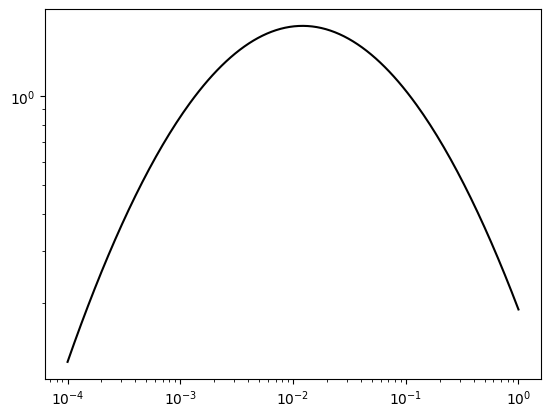

In [2]:
kk = np.logspace(-4, 0, 200)
pk = lognorm.pdf(kk, 2.1) 

plt.plot(kk, pk, 'k')
plt.xscale('log')
plt.yscale('log')
plt.show()

Here is how to call and configure the `FFTLog`
- `Nmax` is the number of log-spaced points used to perform the FFT  
- `xmin` and `xmax` are the FFT boundaries. If the function to FFT is specified on a domain smaller than `[xmin, xmax]`, it will be extrapolated in log-log space. It is usually a good idea to choose the range a bit larger than the domain over which we want the decomposition to be faithful to the original （see also comment below). 
- `bias` is a real non-integer number that can be chosen to assure convergence of certain integrals using the FFTLog decomposition

In [3]:
fftsettings = dict(Nmax=512, xmin=1e-5, xmax=1e3, bias=-.1, complex=False, window=0.1, hankl=True, ells=[0,2,4])
fft = FFTLog(**fftsettings)

Here is the FFTLog decomposition of the `pk`  
- In general, it is a good idea to apply a `window` to the function (beyond the domain where we want its decomposition to be faithful to the original) on the left and right to let it goes smoothly to 0 in order to avoid ringing effect. 

In [4]:
pk_rec = fft.sumCoefxPow(kk, pk, kk) # input k, input pk, output k

In [5]:
pk_rec_2 = fft.rec(kk, pk, kk)

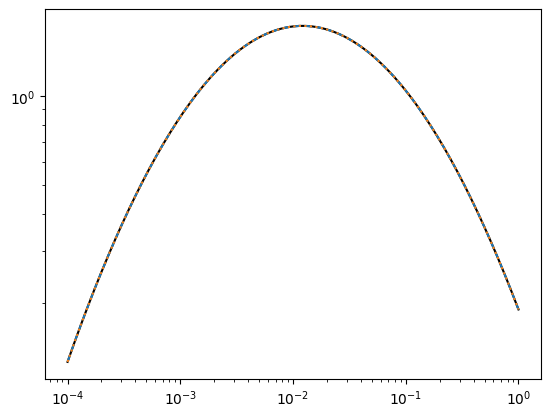

In [6]:
plt.plot(kk, pk, 'k')
plt.plot(kk, pk_rec, '--')
plt.plot(kk, pk_rec_2, ':')

plt.xscale('log')
plt.yscale('log')
plt.show()

### Interlude: Spherical Bessel Transform: $\mathcal{O}(N_{fft} N_s)$-sum vs. $\mathcal{O}(N_{fft} \log N_{fft})$-ifft

In [12]:
from fftlog.sbt import SBT
sbt = SBT(to_fourier=False, ells=[0,2,4])
xi = sbt.get_transform(kk, pk) # fft+sum

In [13]:
s = np.arange(1., 1e3, 5.)
f_y = fft.sbt(kk, pk, s) # fft+ifft

(-0.001, 0.01)

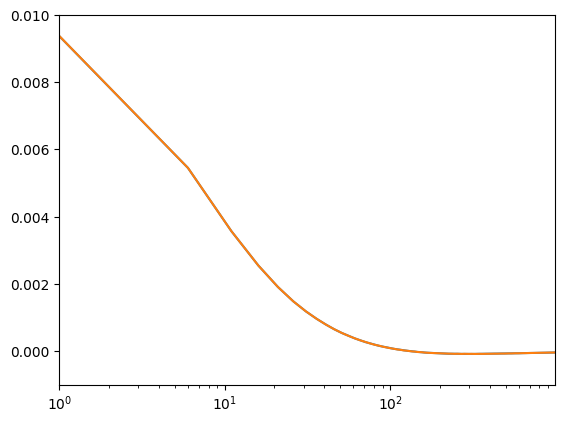

In [14]:
# plt.plot(s, s**2 * f_y[0])
plt.plot(s, s**2 * f_y[0])
plt.plot(s, s**2 * xi[0])
plt.xscale('log')
plt.xlim(s[0], s[-1])
plt.ylim(-.001, 0.01)

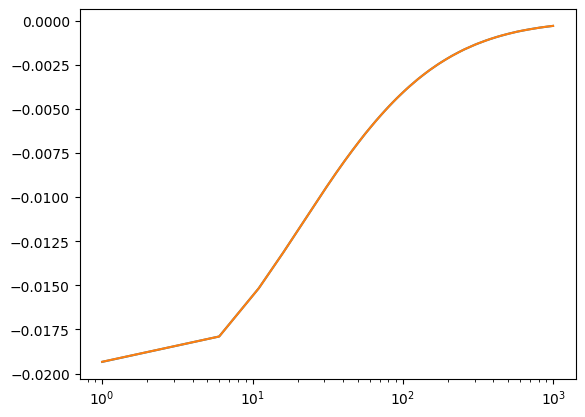

In [15]:
plt.plot(s, s**2 * f_y[1])
plt.plot(s, s**2 * xi[1])
plt.xscale('log')

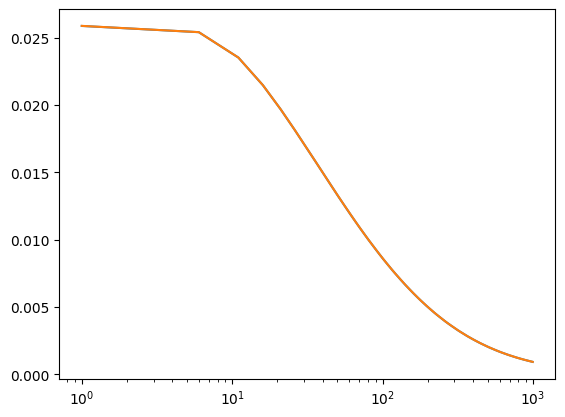

In [16]:
plt.plot(s, s**2 * f_y[2])
plt.plot(s, s**2 * xi[2])
plt.xscale('log')

Timing?

In [17]:
%timeit fft.Coef(kk, pk) # rfft

150 µs ± 6.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%timeit fft.rec(kk, pk) # + irfft

152 µs ± 6.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%timeit fft.rec(kk, pk, kk) # + interpolation 

271 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
%timeit fft.sbt(kk, pk, s) # rfft+irfft+interp

705 µs ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%timeit fft.sumCoefxPow(kk, pk, kk) # rfft+sum

20.2 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit sbt.get_transform(kk, pk) # rfft+sum

1.61 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### End of interlude

In [9]:
%timeit for i in range(1000): _ = fft.Coef(kk, pk)

134 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Note that this timing, and in the rest of the notebook, is for 1000 fftlog's**

### Parallel mode

In [10]:
pks = np.vstack([pk for i in range(1000)])

In [11]:
%timeit _ = fft.Coef(kk, pks)

28.1 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### `jax`-mode

In [12]:
from fftlog.config import set_jax_enabled
set_jax_enabled(True)
from jax import jit
import jax.numpy as jnp

In [11]:
fft = FFTLog(**fftsettings)

with jax

In [12]:
pk_rec = fft.sumCoefxPow(kk, pk, kk)
_ = fft.Coef(kk, pk)

with `jit`

In [13]:
get_coef_jit = jit(fft.Coef)

In [14]:
kk_, pk_ = jnp.array(kk), jnp.array(pk)

jitting

In [15]:
_ = get_coef_jit(kk_, pk_)

now jitted

In [16]:
%timeit for i in range(1000): _ = get_coef_jit(kk_, pk_)

62.7 ms ± 4.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Parallel `jax`-mode

In [17]:
pks_ = jnp.array(pks)

In [18]:
%timeit _ = get_coef_jit(kk_, pks_)

The slowest run took 5.94 times longer than the fastest. This could mean that an intermediate result is being cached.
37.9 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
